<a href="https://colab.research.google.com/github/yk-Jeong/autism/blob/main/autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. lib and dataset load 

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

#google drive와 colab을 연결

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/autism/autismdiagnosis.zip'

test = pd.read_csv('/content/Autism_Prediction/test.csv')
train = pd.read_csv('/content/Autism_Prediction/train.csv')

Archive:  /content/drive/MyDrive/autism/autismdiagnosis.zip
  inflating: Autism_Prediction/sample_submission.csv  
  inflating: Autism_Prediction/test.csv  
  inflating: Autism_Prediction/train.csv  


In [3]:
# 개형 및 표본의 수 확인 

train.shape, test.shape 

((800, 22), (200, 21))

Columns
- ID - ID of the patient
- A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
- age - Age of the patient in years
- gender - Gender of the patient
- ethnicity - Ethnicity of the patient
- jaundice - Whether the patient had jaundice at the time of birth
- **autism** - Whether an immediate family member has been diagnosed with autism
- contry_of_res - Country of residence of the patient
- used_app_before - Whether the patient has undergone a - screening test before
- result - Score for AQ1-10 screening test
- age_desc - Age of the patient
- relation - Relation of patient who completed the test
- Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

In [4]:
# 편리하게 보고자 T 

train.head().T

,0,1,2,3,4
ID,1,2,3,4,5
A1_Score,1,0,1,0,0
A2_Score,0,0,1,0,0
A3_Score,1,0,1,0,0
A4_Score,0,0,1,0,0
A5_Score,1,0,1,0,0
A6_Score,0,0,1,0,0
A7_Score,1,0,1,0,0
A8_Score,0,0,1,0,0
A9_Score,1,0,1,0,0


In [5]:
train['Class/ASD']

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    0
799    0
Name: Class/ASD, Length: 800, dtype: int64

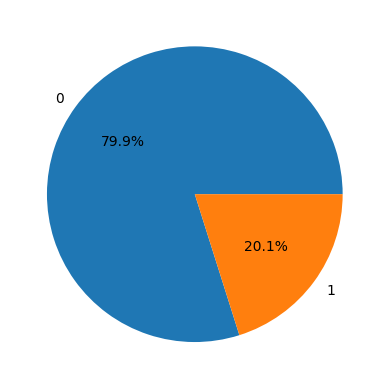

In [6]:
# 정답 레이블의 불균형도 확인

data = [sum(train['Class/ASD'] == 0), sum(train['Class/ASD'] == 1)]
labels = ['0', '1']
plt.pie(data, labels=labels, autopct='%.1f%%')
plt.show()

의문과 문제상황

- 거주지역(Country of residence)의 그룹화 여부 
- 각 컬럼별 결측치 및 그 비중에 따른 처리(특히 ethnicity)
- 오버샘플링 여부 결정
- 개별 문항에 대한 응답을 제거할 것인지 둘 것인지 

In [7]:
# ethnicity의 결측치 비중 확인: 결측치가 전체의 약 1/4로 지나치게 큼 

sum(train['ethnicity'] == '?')

203

In [8]:
# 질적변수별 종류 확인

train['ethnicity'].unique(), train['contry_of_res'].unique(), train['gender'].unique(), train['used_app_before'].unique(), train['age_desc'].unique(), train['relation'].unique()

(array(['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
        'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino',
        'others'], dtype=object),
 array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
        'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
        'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
        'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
        'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia',
        'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan',
        'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong',
        'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran',
        'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone',
        'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium',
        'Burundi', 'Bangladesh'], dtype=object),
 array(['f', 'm'], dtype=object),
 array(['no', 

### 1. EDA

- 컬럼명 변경: Contry_of_res -> residence, austim -> autism
- 대소문자 표기 일치
- ethnicity, relation 컬럼의 결측치: Unknown으로 처리
- used_app_before 컬럼의 응답 변경: yes: 1, no: 0


In [9]:
train['age_desc'].unique()

# age_desc: 모두 동일한 값만 들어있으므로 불필요한 컬럼 -> 삭제 
train.drop('age_desc', axis=1, inplace=True)
test.drop('age_desc', axis=1, inplace=True)

# ID: 개인 구분이므로 삭제 
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [10]:
# 컬럼명 오타 수정 및 변경: Contry_of_res -> residence, austim -> autism

train.rename(columns={'austim':'autism'}, inplace=True)
test.rename(columns={'austim':'autism'}, inplace=True)

train.rename(columns={'contry_of_res':'residence'}, inplace=True)
test.rename(columns={'contry_of_res':'residence'}, inplace=True)

In [11]:
# yes: 1, no: 2로 수정
# 첫 글자는 대문자로 고정(others만 수정)

def replace(df):
  df.replace({'yes':1, 'no':0, '?':'Unknown'}, inplace=True)
  df.replace({'others':'Others'}, inplace=True)

replace(train), replace(test)

(None, None)

In [12]:
# 확인 

train.head().T

,0,1,2,3,4
A1_Score,1,0,1,0,0
A2_Score,0,0,1,0,0
A3_Score,1,0,1,0,0
A4_Score,0,0,1,0,0
A5_Score,1,0,1,0,0
A6_Score,0,0,1,0,0
A7_Score,1,0,1,0,0
A8_Score,0,0,1,0,0
A9_Score,1,0,1,0,0
A10_Score,1,0,1,0,0


In [13]:
# 수치형 feature들만 골라서 기술통계량 확인

train[['age', 'result']].describe()

,age,result
count,800.000000,800.000000
mean,28.452118,8.537303
std,16.310966,4.807676
min,2.718550,-6.137748
25%,17.198153,5.306575
50%,24.848350,9.605299
75%,35.865429,12.514484
max,89.461718,15.853126


### 2. Feature Engineering
- One-hot encoding
- Residence Grooping 

In [14]:
# One-hot encoding: 'gender', 'used_app_before'



In [15]:
train['UN regional groups'] = 0
train.T

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
A1_Score,1,0,1,0,0,1,1,1,1,0,...,1,0,1,0,0,0,0,0,0,0
A2_Score,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,1,1,0,0,1
A3_Score,1,0,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
A4_Score,0,0,1,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
A5_Score,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,0,0,0,0
A6_Score,0,0,1,0,0,1,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
A7_Score,1,0,1,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
A8_Score,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,1,0,1,0,0,0
A9_Score,1,0,1,0,0,1,1,1,1,0,...,1,0,0,0,0,1,1,0,0,0
A10_Score,1,0,1,0,0,1,0,1,1,1,...,0,1,0,0,0,1,1,0,0,0


In [16]:
# residence grooping 

def country_grooping(df): 
  if df['residence'] == ['South Africa' or 'Egypt' or 'Ethiopia' or 'Angola' or 'Sierra Leone' or 'Burundi' or 'Niger'] :
    df['UN regional groups'] = 'African'     
  elif df['residence'] == 'India' or 'Jordan'or 'Kazakhstan'or 'United Arab Emirates'or 'Iraq'or 'Malaysia'or 'Viet Nam'or 'Afghanistan'or 'Saudi Arabia'or 'Hong Kong'or 'Japan'or 'AmericanSamoa'or 'Oman'or 'Sri Lanka'or 'China'or 'Tonga'or 'Pakistan'or 'Bangladesh'or 'Iran'or 'Cyprus':
    df['UN regional groups'] = 'Asia-Pacific'
  elif df['residence'] == 'Ukraine' or 'Russia' or 'Azerbaijan'or 'Armenia'or 'Serbia'or 'Czech Republic'or 'Romania':
    df['UN regional groups'] = 'Eastern European'
  elif df['residence'] == 'Brazil' or 'Bahamas' or 'Bolivia'or 'Mexico'or 'Nicaragua'or 'Argentina'or 'Aruba':
    df['UN regional groups'] = 'GRULAC'
  else:
    df['UN regional groups'] = 'WEOG'

In [17]:
country_grooping(train)

ValueError: ignored

### 3. Data split

In [ ]:
# target column 지정

target = 'Class/ASD'

y_train = train[target]
X_train = train.iloc[:, 0:-1]
X_test = test

In [ ]:
X_train.shape, X_test.shape, y_train.shape

In [ ]:
# Valid set 설정 



### 4. Modeling 

## 5. 성능 향상